# 1) Importando Bibliotecas

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from math import ceil  

import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid, KFold

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.options.display.max_columns=100 
pd.options.display.max_rows=100

# 2) Funções

In [2]:
def find_missing_percent(data):
    """
    Retorna dataframe contendo o total de valores faltantes e porcentagem do total
    de valores faltantes da coluna.
    """
    miss_df = pd.DataFrame({'ColumnName':[],'TotalMissingVals':[],'PercentMissing':[]})
    for col in data.columns:
        sum_miss_val = data[col].isnull().sum()
        percent_miss_val = round((sum_miss_val/data.shape[0])*100,2)
        miss_df.loc[len(miss_df)] = dict(zip(miss_df.columns,[col,sum_miss_val,percent_miss_val]))
    return miss_df

In [3]:
def find_correlated_columns(df, interval):
    """
    Encontra e exibe as correlações entre colunas de um DataFrame.

    Parâmetros:
    - df: DataFrame pandas
    - intervalo de correlação desejado (uma tupla de dois valores)

    Retorna:
    - Lista de tuplas representando pares de colunas correlacionadas.
    """
    correlation_matrix = df.corr(numeric_only=True)
    correlated_columns = []

    # Iterar sobre as combinações de colunas para encontrar correlações
    for i in range(len(correlation_matrix.columns)):
        for j in range(i + 1, len(correlation_matrix.columns)):
            corr = correlation_matrix.iloc[i, j]
            if interval[0] <= abs(corr) <= interval[1]:
                col1 = correlation_matrix.columns[i]
                col2 = correlation_matrix.columns[j]
                correlated_columns.append((col1, col2))
                print(f"Correlação entre {col1} e {col2}: {corr}")

    # Plotar um mapa de calor da matriz de correlação
    plt.figure(figsize=(20, 16))
    sns.heatmap(correlation_matrix, annot=True, cmap='cubehelix_r')
    plt.title('Matriz de Correlação')
    plt.xlabel('Variáveis')
    plt.ylabel('Variáveis')
    plt.show()

    return correlated_columns

In [4]:
def correlacao_com_variavel_alvo(df, target_variable, nivel="forte", top_n=5):
    """
    Imprime as n features com as maiores correlações com uma variável alvo, com base no nível escolhido.

    Parâmetros:
    - df: DataFrame pandas.
    - target_variable: String, nome da variável alvo.
    - nivel: String que define o critério de correlação ("forte", "fraca", etc.).
    - top_n: Número inteiro, quantidade de features a serem impressas.

    Retorna:
    - Nenhum (imprime as correlações).
    """
    correlation_matrix = df.corr(numeric_only=True)

    # Filtra as correlações com base no nível escolhido
    if nivel.lower() == "forte":
        filtered_correlations = correlation_matrix[((correlation_matrix >= 0.7) & (correlation_matrix < 1.0)) | ((correlation_matrix <= -0.7) & (correlation_matrix > -1.0))]
    else:
        raise ValueError("Nível não suportado. Atualmente, apenas 'forte' é suportado.")

    # Filtra as correlações com a variável alvo
    correlations_with_target = filtered_correlations[target_variable].sort_values(ascending=False)

    # Pegar as n maiores correlações
    top_n_correlations = correlations_with_target.head(top_n)

    # Imprimir as n maiores correlações com a variável alvo
    print(f"As {top_n} maiores correlações com '{target_variable}' ({nivel}):")
    for feature, correlation in top_n_correlations.items():
        print(f"{feature}: {correlation}")


# 3) Processamento dos Dados

Os valores outliers já foram tratados na etapa de limpeza dos dados, agora cabe lidar com os valores nulos para viabilizar a utilização dos modelos de Machine Learning

In [5]:
df1 = pd.read_csv('base_limpa1.csv', index_col=0)
df2 = pd.read_csv('base_limpa2.csv', index_col=0)

df = pd.concat([df1, df2])

In [6]:
# Mantendo somente os pedidos que não foram cancelados para que possamos analisar os tempos de entrega
# São pouco mais de 30k em 350k de linhas disponíveis
df = df[~df['order_status'].eq('CANCELED')]

df.reset_index(drop=True, inplace=True)

In [7]:
df['order_date'] = pd.to_datetime(df['order_date'])
df['order_moment_accepted'] = pd.to_datetime(df['order_moment_accepted'])

# Criando colunas para facilitar análises
# Colunas para o tempo de realização do pedido
df['minute_rea'] = df['order_date'].dt.minute
df['hour_rea'] = df['order_date'].dt.hour
df['day_rea'] = df['order_date'].dt.day
df['month_rea'] = df['order_date'].dt.month
df['year_rea'] = df['order_date'].dt.year
df['weekday_rea'] = df['order_date'].dt.weekday # Domingo é 0

# Colunas para o tempo de aceitação do pedido
df['minute_ac'] = df['order_moment_accepted'].dt.minute
df['hour_ac'] = df['order_moment_accepted'].dt.hour
df['day_ac'] = df['order_moment_accepted'].dt.day
df['month_ac'] = df['order_moment_accepted'].dt.month
df['year_ac'] = df['order_moment_accepted'].dt.year
df['weekday_ac'] = df['order_moment_accepted'].dt.weekday # Domingo é 0

# Tempo para aceitar o pedido
df['dif_tempo'] = df['order_moment_accepted'] - df['order_date']
df['min_para_aceitar'] = df['dif_tempo'].apply(lambda x: round(x.total_seconds() / 60 ,2))

df.drop(columns=['order_date', 'order_moment_accepted', 'dif_tempo'], axis=1, inplace=True)

In [8]:
# removendo colunas que não serão úteis para prever o tempo de entrega, já que não teremos informações delas no momento do pedido
col_del = ['order_status', 'payment_status', 'delivery_status', 'order_moment_ready', 'order_moment_collected',
       'order_moment_in_expedition', 'order_moment_delivering',
       'order_moment_finished', 'order_metric_collected_time',
       'order_metric_paused_time', 'order_metric_production_time',
       'order_metric_walking_time', 'order_metric_expediton_speed_time',
       'order_metric_transit_time']

col_del = col_del
df.drop(col_del, axis=1, inplace=True)

In [9]:
find_missing_percent(df)

,ColumnName,TotalMissingVals,PercentMissing
0,hub_name,0,0.00
1,hub_city,0,0.00
2,hub_state,0,0.00
3,store_name,0,0.00
4,store_segment,0,0.00
5,store_plan_price,77730,23.10
6,driver_modal,6118,1.82
7,driver_type,6118,1.82
8,delivery_distance_meters,2712,0.81
9,payment_amount,1038,0.31


In [10]:
linhas_antes = df.shape[0]
# Removendo pedidos sem o tempo de entrega 'order_metric_cycle_time'
df = df[~df['order_metric_cycle_time'].isnull()]

In [11]:
# REMOVENDO TEMPORARIAMENTE A COLUNA store_plan_price
df.drop(columns=['store_plan_price'], axis=1, inplace=True)

# REMOVENDO TEMPORARIAMENTE TODAS AS LINHAS COM VALORES NULOS PARA TREINAR O MODELO LOGO
df.dropna(axis=0, inplace=True)


df.reset_index(drop=True, inplace=True)

linhas_depois = df.shape[0]
print(f'apaguei {linhas_antes - linhas_depois} linhas e restam {round(100*linhas_depois / linhas_antes)}% do df')

apaguei 9322 linhas e restam 97.229100096604 do df


In [12]:
#df['store_plan_price'].fillna(0, inplace=True)

In [13]:
'''
for column in ['driver_modal', 'driver_type', 'payment_method', 'payment_status']:
    df[column].fillna(df[column].mode()[0], inplace=True)

for column in ['delivery_distance_meters',  'payment_amount', 'payment_fee', 
                'order_delivery_cost']:
    df[column].fillna(df[column].median(), inplace=True)



# Preencher NaN em 'delivery_status' com 'DELIVERED' onde 'order_metric_cycle_time' não é NaN
df.loc[df['order_metric_cycle_time'].notnull() & df['delivery_status'].isnull(), 'delivery_status'] = 'DELIVERED'

# Calcular o segundo valor mais frequente em 'delivery_status'
second_most_frequent_value = df['delivery_status'].value_counts().index[1]

# Preencher NaN em 'delivery_status' com o segundo valor mais frequente
df['delivery_status'].fillna(second_most_frequent_value, inplace=True)


# Condição para preencher apenas quando delivery_status for 'DELIVERED'
condition = df['delivery_status'] == 'DELIVERED'

# Lista das colunas a serem preenchidas com a mediana
columns_to_fill = [
    'order_metric_production_time', 
    'order_metric_expediton_speed_time', 
    'order_metric_transit_time', 
    'order_metric_collected_time', 
    'order_metric_paused_time', 
    'order_metric_walking_time',
    'order_metric_cycle_time'  # Adicionando 'order_metric_cycle_time' à lista
]

# Preencher os valores faltantes com a mediana nas colunas específicas quando delivery_status for 'DELIVERED'
for column in columns_to_fill:
    median_value = df.loc[condition, column].median()
    df.loc[condition & df[column].isnull(), column] = median_value
'''

"\nfor column in ['driver_modal', 'driver_type', 'payment_method', 'payment_status']:\n    df[column].fillna(df[column].mode()[0], inplace=True)\n\nfor column in ['delivery_distance_meters',  'payment_amount', 'payment_fee', \n                'order_delivery_cost']:\n    df[column].fillna(df[column].median(), inplace=True)\n\n\n\n# Preencher NaN em 'delivery_status' com 'DELIVERED' onde 'order_metric_cycle_time' não é NaN\ndf.loc[df['order_metric_cycle_time'].notnull() & df['delivery_status'].isnull(), 'delivery_status'] = 'DELIVERED'\n\n# Calcular o segundo valor mais frequente em 'delivery_status'\nsecond_most_frequent_value = df['delivery_status'].value_counts().index[1]\n\n# Preencher NaN em 'delivery_status' com o segundo valor mais frequente\ndf['delivery_status'].fillna(second_most_frequent_value, inplace=True)\n\n\n# Condição para preencher apenas quando delivery_status for 'DELIVERED'\ncondition = df['delivery_status'] == 'DELIVERED'\n\n# Lista das colunas a serem preenchidas 

In [14]:
# Vamos listar as features que vamos utilizar
input_cols_categoric = ['hub_state', 'store_segment', 'channel_type', 'driver_modal']
input_cols_numeric = ['delivery_distance_meters', 'payment_amount', 'payment_fee', 'order_amount',  
                    'minute_rea', 'hour_rea', 'day_rea', 'month_rea', 'year_rea',
                     'weekday_rea', 'minute_ac', 'hour_ac','day_ac', 'month_ac', 
                     'year_ac', 'weekday_ac', 'min_para_aceitar']
features = input_cols_categoric + input_cols_numeric

target = 'order_metric_cycle_time'

In [15]:
# Dividindo os dados antes de qualquer pré-processamento
X = df[features]  
y = df[target]  

# Divide em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=999
)

In [16]:
# Tratando as variáveis categóricas 

encoder = ce.OneHotEncoder(cols=input_cols_categoric, handle_unknown='ignore')

X_train = encoder.fit_transform(X_train)

X_test = encoder.transform(X_test)

# DecisionTreeRegressor


In [17]:
dt = DecisionTreeRegressor()
dt.fit(X_train,y_train)

y_pred1 = dt.predict(X_test)

In [18]:
mse = mean_squared_error(y_test, y_pred1)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test,y_pred1)
r2 = r2_score(y_test, y_pred1)
print(f'MSE:{mse} | RMSE:{rmse} | MAE:{mae} | R2:{r2}')

MSE:242.62998119869766 | RMSE:15.576584388071014 | MAE:11.05828403723575 | R2:-0.39932590713037475


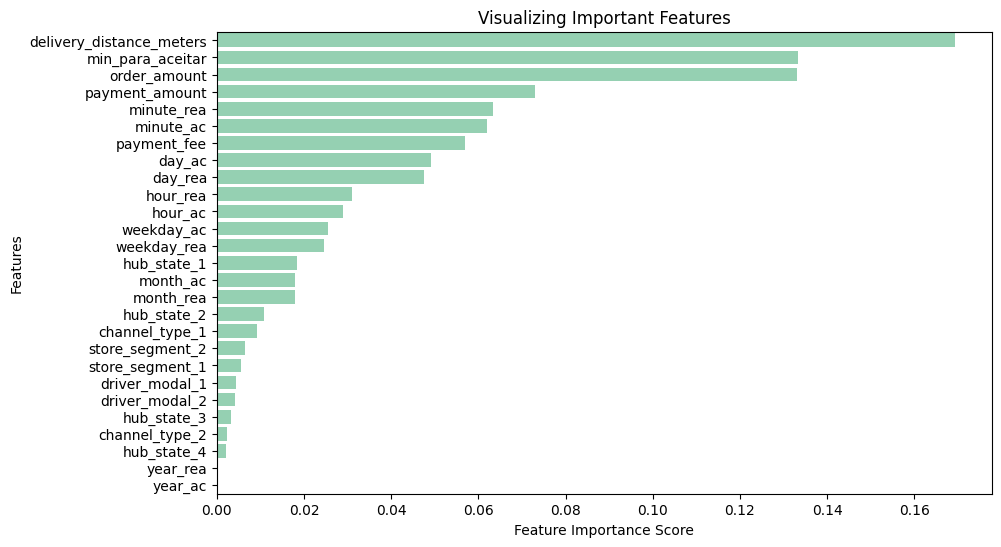

In [19]:
# FEATURE IMPORTANCE
feature_imp = pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(
    ascending=False
)

# Escolhendo paleta
sns.set_palette("mako_r")

# Creating a bar plot
_ = plt.figure(figsize=(10, 6))
_ = sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
_ = plt.xlabel("Feature Importance Score")
_ = plt.ylabel("Features")
_ = plt.title("Visualizing Important Features")

# LogisticRegression

In [20]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

y_pred2 = dt.predict(X_test)

c:\Users\Apple\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [33]:
mse = mean_squared_error(y_test, y_pred2)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test,y_pred2)
r2 = r2_score(y_test, y_pred2)
print(f'MSE:{mse} | RMSE:{rmse} | MAE:{mae} | R2:{r2}')

MSE:242.62998119869766 | RMSE:15.576584388071014 | MAE:11.05828403723575 | R2:-0.39932590713037475


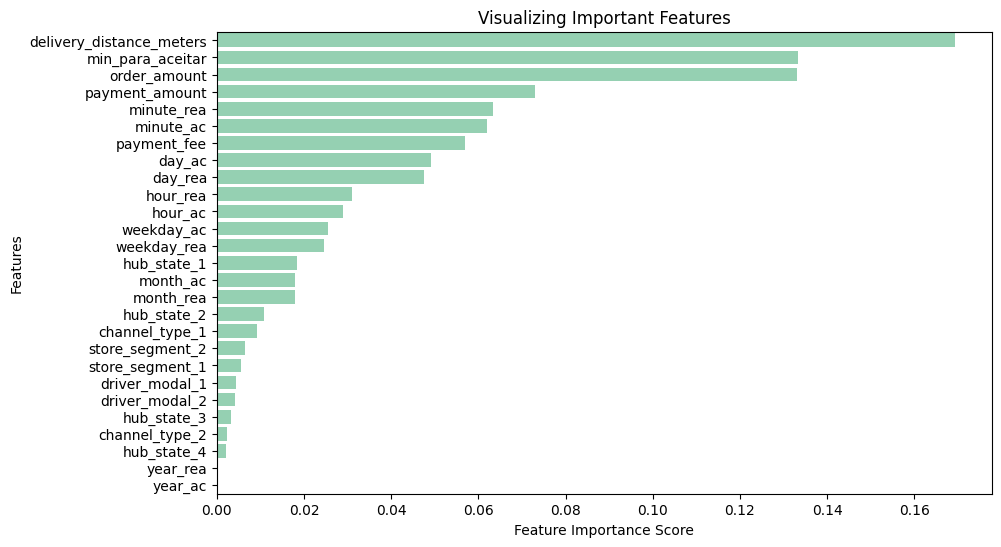

In [22]:
# FEATURE IMPORTANCE
feature_imp = pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(
    ascending=False
)

# Escolhendo paleta
sns.set_palette("mako_r")

# Creating a bar plot
_ = plt.figure(figsize=(10, 6))
_ = sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
_ = plt.xlabel("Feature Importance Score")
_ = plt.ylabel("Features")
_ = plt.title("Visualizing Important Features")

# RandomForestRegressor

In [23]:
reg_RF = RandomForestRegressor(n_estimators = 100, random_state=0, n_jobs=1)  
reg_RF.fit(X_train, y_train) 

y_pred = reg_RF.predict(X_test)

In [24]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test,y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE:{mse} | RMSE:{rmse} | MAE:{mae} | R2:{r2}')

MSE:118.39932157411228 | RMSE:10.881145232654157 | MAE:8.26654912031305 | R2:0.31715265670471515


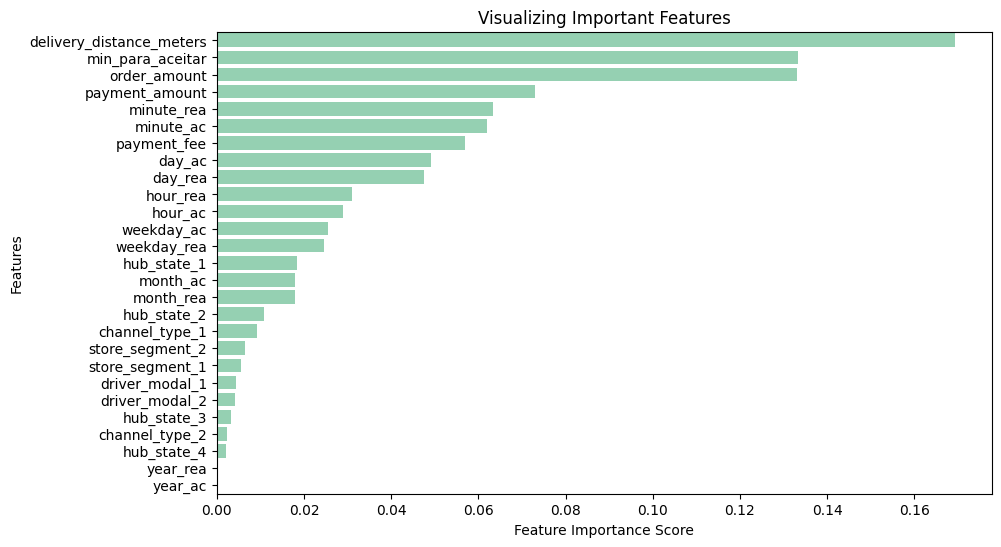

In [25]:
# FEATURE IMPORTANCE
feature_imp = pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(
    ascending=False
)

# Escolhendo paleta
sns.set_palette("mako_r")

# Creating a bar plot
_ = plt.figure(figsize=(10, 6))
_ = sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
_ = plt.xlabel("Feature Importance Score")
_ = plt.ylabel("Features")
_ = plt.title("Visualizing Important Features")

In [26]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint

# Tunando os hiperparâmetros:
model_params = {
    # randomly sample numbers from 4 to 204 estimators
    "n_estimators": randint(4, 200),
    # normally distributed max_features, with mean .25 stddev 0.1, bounded between 0 and 1
    "max_features": truncnorm(a=0, b=1, loc=0.25, scale=0.1),
    # uniform distribution from 0.01 to 0.2 (0.01 + 0.199)
    "min_samples_split": uniform(0.01, 0.199),
}

# create random forest regressor model
rf_model = RandomForestRegressor()

# set up random search meta-estimator
# this will train 10 models over 5 folds of cross validation (50 models total)
clf = RandomizedSearchCV(rf_model, model_params, n_iter=10, cv=5, random_state=1)

# train the random search meta-estimator to find the best model out of 100 candidates
model = clf.fit(X_train, y_train)

# print winning set of hyperparameters
from pprint import pprint

pprint(model.best_estimator_.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 0.2735795124259265,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 0.02178939705901113,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 34,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [27]:
# Qual combinação de parâmetros trouxe melhor resultado:
model.best_estimator_

RandomForestRegressor(max_features=0.2735795124259265,
                      min_samples_split=0.02178939705901113, n_estimators=34)

In [31]:
reg_random = RandomForestRegressor(max_features=0.2735795124259265,
                      min_samples_split=0.02178939705901113, n_estimators=34)

reg_random.fit(X_train, y_train)

RandomForestRegressor(max_features=0.2735795124259265,
                      min_samples_split=0.02178939705901113, n_estimators=34)

In [32]:
y_pred_random = reg_random.predict(X_test)

mse = mean_squared_error(y_test, y_pred_random)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test,y_pred_random)
r2 = r2_score(y_test, y_pred_random)
print(f'MSE:{mse} | RMSE:{rmse} | MAE:{mae} | R2:{r2}')

MSE:147.5383849032527 | RMSE:12.14653798015108 | MAE:9.383318741170017 | R2:0.14909821419710578


# XGBRegressor